In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lines = []
with open("result.txt", "r") as fp:
    for line in fp:
        lines.append(list(map(float, line.strip().split())))

In [3]:
dat = np.array(lines, dtype=np.float64)
y = np.linspace(-0.2, 4.2, dat.shape[0])
x = np.linspace(-3.2, 3.2, dat.shape[1]),
X, Y = np.meshgrid(x, y)
Z = dat

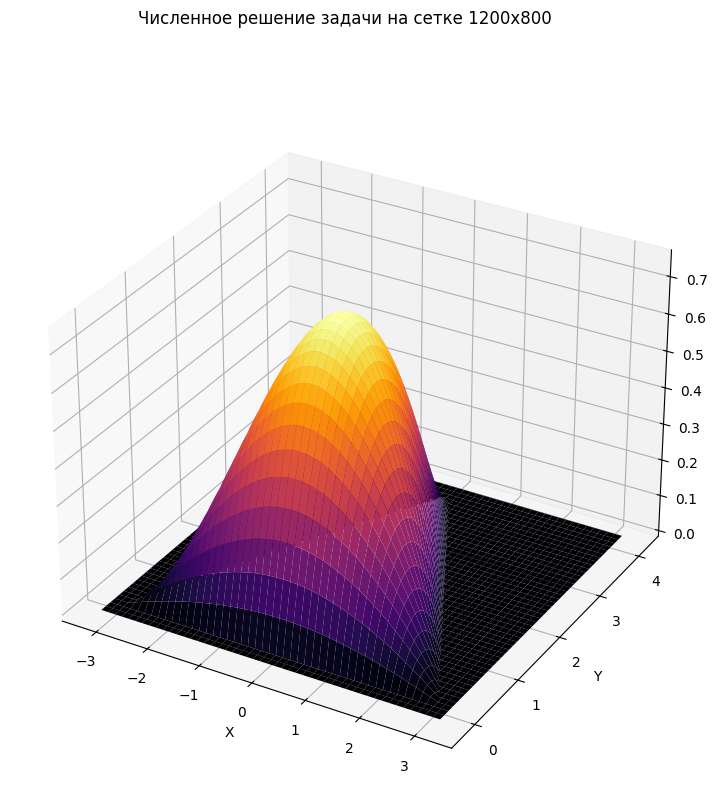

In [4]:
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
fig.suptitle("Численное решение задачи на сетке 1200x800")
ax.plot_surface(X, Y, Z, cmap="inferno")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(30)
fig.savefig("solution_plot.png")
plt.show()

In [5]:
ystep = 4.4 / dat.shape[0]
xstep = 6.4 / dat.shape[1]

residual = (
    -(dat[2:, 1:-1] - 2 * dat[1:-1, 1:-1] + dat[:-2, 1:-1]) / (ystep**2)
    -(dat[1:-1, 2:] - 2 * dat[1:-1, 1:-1] + dat[1:-1, :-2]) / (xstep**2)
    -1.
)

Text(0, 0.5, 'y')

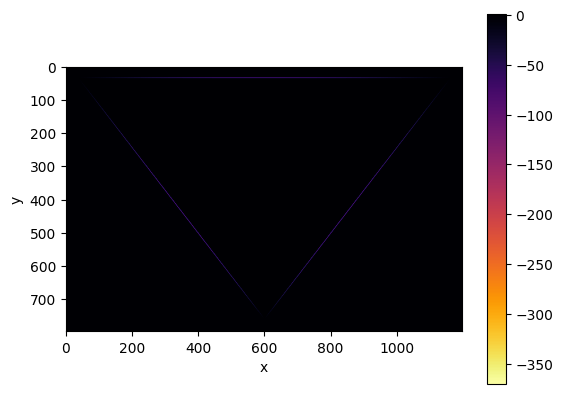

In [6]:
plt.imshow(residual, cmap="inferno_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

In [7]:
import os
import pandas as pd


def parse_elapsed_time(path):
    elapsed_time = None
    with open(path, "r") as fp:
        for line in fp:
            if "Elapsed time:" in line:
                elapsed_time = float(line.split("Elapsed time: ")[1].split(" seconds")[0])
    return elapsed_time


def parse_iter_num(path):
    iter_num = 0
    with open(path, "r") as fp:
        for line in fp:
            if line.startswith("Step "):
                iter_num = int(line.split("Step ")[1].split(":")[0]) + 1
    return iter_num


if __name__ == "__main__":
    results = []

    cpu_prefix = "bsub_results/cpu"
    for path in os.listdir(cpu_prefix):
        full_path = os.path.join(cpu_prefix, path)
        grid_size = path.split("_")[1].split(".txt")[0]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": "cpu",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": 1,
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": 1.,
                    "id": 0,
                }
            )
    cpu_df = pd.DataFrame(results)

    omp_prefix = "bsub_results/omp"
    for path in os.listdir(omp_prefix):
        full_path = os.path.join(omp_prefix, path)
        grid_size = path.split("_")[1]
        num_threads = path.split("_")[2].split(".txt")[0]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": f"omp_{num_threads}",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": int(num_threads),
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": float(cpu_df.loc[cpu_df.grid_size==grid_size, "elapsed_time"].to_numpy()[0]) / elapsed_time,
                    "id": 1,
                }
            )

    mpi_prefix = "bsub_results/mpi"
    for path in os.listdir(mpi_prefix):
        full_path = os.path.join(mpi_prefix, path)
        grid_size = path.split("_")[1]
        num_threads = path.split("_")[2].split(".txt")[0]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": f"mpi_{num_threads}",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": int(num_threads),
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": float(cpu_df.loc[cpu_df.grid_size==grid_size, "elapsed_time"].to_numpy()[0]) / elapsed_time,
                    "id": 2,
                }
            )
    combo_prefix = "bsub_results/combo"
    for path in os.listdir(combo_prefix):
        full_path = os.path.join(combo_prefix, path)
        grid_size = path.split("_")[1]
        num_cores = path.split("_")[2]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": f"combo_{num_cores}",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": int(num_cores.split("x")[0]) * int(num_cores.split("x")[1]),
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": float(cpu_df.loc[cpu_df.grid_size==grid_size, "elapsed_time"].to_numpy()[0]) / elapsed_time,
                    "id": 2,
                }
            )

    res = (
        pd.DataFrame(results)
        .sort_values(by=["xdim", "id", "num_threads"])
    )

In [8]:
res

,kind,grid_size,iter_num,elapsed_time,num_threads,xdim,speedup,id
1,cpu,600x400,477,3.6400,1,600,1.000000,0
9,omp_2,600x400,477,1.9300,2,600,1.886010,1
3,omp_4,600x400,477,2.0960,4,600,1.736641,1
11,omp_8,600x400,477,1.7160,8,600,2.121212,1
8,omp_16,600x400,477,1.2380,16,600,2.940226,1
6,omp_32,600x400,477,0.7550,32,600,4.821192,1
17,mpi_2,600x400,478,1.9945,2,600,1.825019,2
21,combo_2x1,600x400,478,1.8620,2,600,1.954887,2
27,combo_2x1,600x400,478,1.8760,2,600,1.940299,2
43,combo_2x1,600x400,478,1.8698,2,600,1.946732,2


In [9]:
res_omp = res[res["kind"].str.startswith("omp")].rename(
    columns={
        "num_threads": "Количество нитей OpenMP",
        "speedup": "Ускорение, количество раз",
        "grid_size": "Размер сетки",
    }
)
res_omp

,kind,Размер сетки,iter_num,elapsed_time,Количество нитей OpenMP,xdim,"Ускорение, количество раз",id
9,omp_2,600x400,477,1.930,2,600,1.886010,1
3,omp_4,600x400,477,2.096,4,600,1.736641,1
11,omp_8,600x400,477,1.716,8,600,2.121212,1
8,omp_16,600x400,477,1.238,16,600,2.940226,1
6,omp_32,600x400,477,0.755,32,600,4.821192,1
2,omp_2,1200x800,718,20.732,2,1200,1.122419,1
7,omp_4,1200x800,718,16.223,4,1200,1.434383,1
5,omp_8,1200x800,718,9.362,8,1200,2.485580,1
4,omp_16,1200x800,718,8.491,16,1200,2.740549,1
10,omp_32,1200x800,718,4.921,32,1200,4.728714,1


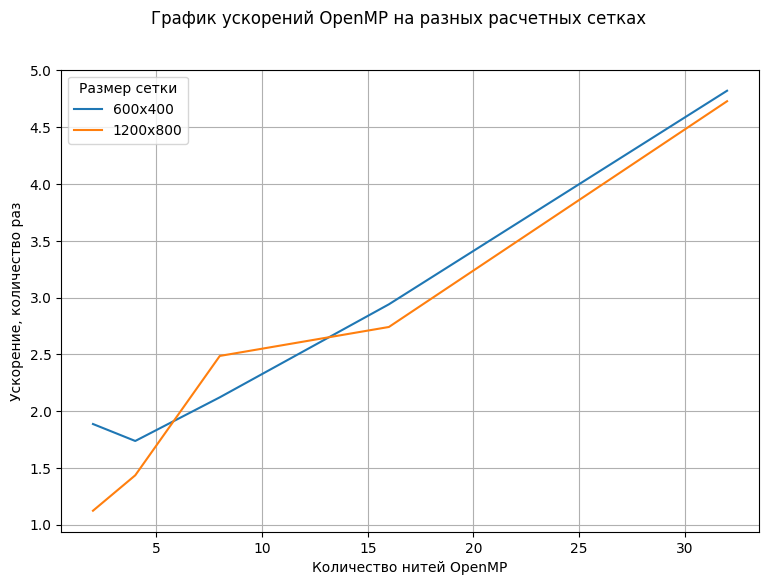

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle("График ускорений OpenMP на разных расчетных сетках")

sns.lineplot(
    res_omp,
    x="Количество нитей OpenMP",
    y="Ускорение, количество раз",
    hue="Размер сетки"
)

ax.grid(True)
fig.savefig("speedup.png")
plt.show()

In [11]:
res_mpi = res[res["kind"].str.startswith("mpi")].rename(
    columns={
        "num_threads": "Количество процессов MPI",
        "speedup": "Ускорение, количество раз",
        "grid_size": "Размер сетки",
    }
)
res_mpi

,kind,Размер сетки,iter_num,elapsed_time,Количество процессов MPI,xdim,"Ускорение, количество раз",id
17,mpi_2,600x400,478,1.9945,2,600,1.825019,2
12,mpi_4,600x400,478,1.1044,4,600,3.295907,2
19,mpi_8,600x400,478,0.8990,8,600,4.048943,2
16,mpi_16,600x400,478,0.6318,16,600,5.761317,2
15,mpi_4,1200x800,718,7.6140,4,1200,3.056212,2
14,mpi_8,1200x800,718,4.5173,8,1200,5.151307,2
13,mpi_16,1200x800,718,2.2757,16,1200,10.225425,2
18,mpi_32,1200x800,718,1.6330,32,1200,14.249847,2


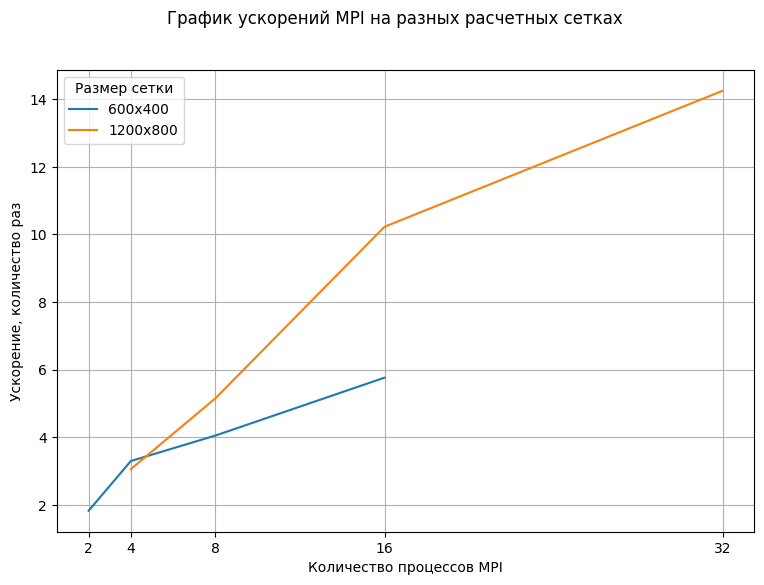

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle("График ускорений MPI на разных расчетных сетках")

sns.lineplot(
    res_mpi,
    x="Количество процессов MPI",
    y="Ускорение, количество раз",
    hue="Размер сетки"
)

xticks = np.logspace(1, 5, num=5, base=2).astype(int)
ax.set_xticks(xticks, xticks)
ax.grid(True)
fig.savefig("speedup.png")
plt.show()

In [13]:
res_combo = res[res["kind"].str.startswith("combo")].rename(
    columns={
        "num_threads": "Количество нитей OpenMP на процесс",
        "speedup": "Ускорение, количество раз",
        "grid_size": "Размер сетки, конфигурация",
    }
).groupby(["kind", "Размер сетки, конфигурация"]).median().reset_index()
res_combo["Размер сетки, конфигурация"] = (
    res_combo["Размер сетки, конфигурация"]
    + ", "
    + res_combo["kind"].apply(lambda x: x.split("_")[1].split("x")[0])
    + " MPI процесса"
)
res_combo

,kind,"Размер сетки, конфигурация",iter_num,elapsed_time,Количество нитей OpenMP на процесс,xdim,"Ускорение, количество раз",id
0,combo_2x1,"600x400, 2 MPI процесса",478.0,1.87240,2.0,600.0,1.944029,2.0
1,combo_2x2,"600x400, 2 MPI процесса",478.0,1.37340,4.0,600.0,2.650357,2.0
2,combo_2x4,"600x400, 2 MPI процесса",478.0,0.77500,8.0,600.0,4.696774,2.0
3,combo_2x8,"600x400, 2 MPI процесса",478.0,0.50720,16.0,600.0,7.176656,2.0
4,combo_4x1,"1200x800, 4 MPI процесса",718.0,5.81620,4.0,1200.0,4.000894,2.0
5,combo_4x2,"1200x800, 4 MPI процесса",718.0,4.44250,8.0,1200.0,5.238042,2.0
6,combo_4x4,"1200x800, 4 MPI процесса",718.0,2.47865,16.0,1200.0,9.388646,2.0
7,combo_4x8,"1200x800, 4 MPI процесса",718.0,1.75780,32.0,1200.0,13.238139,2.0


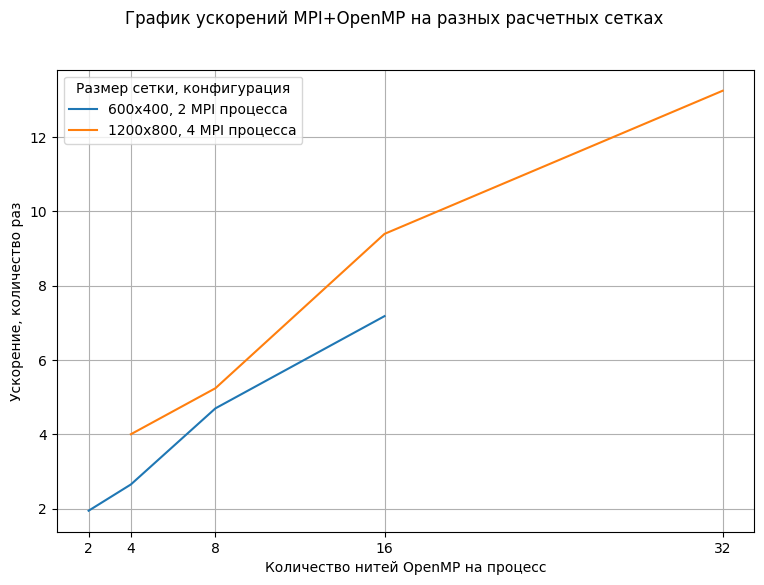

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle("График ускорений MPI+OpenMP на разных расчетных сетках")

sns.lineplot(
    res_combo,
    x="Количество нитей OpenMP на процесс",
    y="Ускорение, количество раз",
    hue="Размер сетки, конфигурация"
)

xticks = np.logspace(1, 5, num=5, base=2).astype(int)
ax.set_xticks(xticks, xticks)
ax.grid(True)
fig.savefig("speedup.png")
plt.show()